In this question, we try to run some code to fit a line and, subsequently, a circle to a set of noisy points that conform to a line and a circle.

In [284]:
import numpy as np
from scipy import optimize
from scipy import linalg
import matplotlib.pyplot as plt
import random
import cv2 as cv
import math

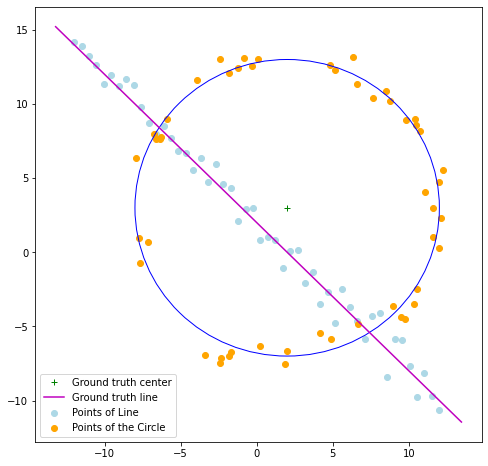

In [285]:
# Code for generating the noisy points
# Seed for reproducibility
np.random.seed(1)

N = 100
half_n = N // 2
r = 10
x0_gt, y0_gt = 2, 3  # Center of the circle
s = r / 16

# Generate points for the circle
theta = np.random.uniform(0, 2 * np.pi, half_n)
noise = s * np.random.randn(half_n)
x_circle = x0_gt + (r + noise) * np.cos(theta)
y_circle = y0_gt + (r + noise) * np.sin(theta)

X_circ = np.column_stack((x_circle, y_circle))

# Generate points for the line
s = 1.0
m, c = -1, 2

x_line = np.linspace(-12, 12, half_n)
y_line = m * x_line + c + s * np.random.randn(half_n)

X_line = np.column_stack((x_line, y_line))

# Concatenate points from both circle and line to create X
X = np.vstack((X_circ, X_line))

# Plot the noisy points, ground truth line, and ground truth circle
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
ax.scatter(X_line[:, 0], X_line[:, 1], color = 'lightblue', label='Points of Line')
ax.scatter(X_circ[:, 0], X_circ[:, 1], color = 'orange', label='Points of the Circle')
circle_gt = plt.Circle((x0_gt, y0_gt), r, color='blue', fill=False, label='Ground truth circle')
ax.add_artist(circle_gt)
ax.plot(x0_gt, y0_gt, '+g', label='Ground truth center')
x_min, x_max = ax.get_xlim()
x_range = np.array([x_min, x_max])
y_range = m * x_range + c
plt.plot(x_range, y_range, color='m', label='Ground truth line')
plt.legend()
plt.show()

In [286]:
#First lets implement a code to find the best fit line using Ransac

# Calculating the equation of a line passing through 2 given points.
# Returns a,b,d parameters

def line_equation_from_points(x1, y1, x2, y2):
    # Calculate the direction vector (Δx, Δy)
    delta_x = x2 - x1
    delta_y = y2 - y1

    # Calculate the normalized vector (a, b)
    magnitude = math.sqrt(delta_x**2 + delta_y**2)
    a = delta_y / magnitude
    b = -delta_x / magnitude

    # Calculate d
    d = (a * x1) + (b * y1)

    # Return the line equation in the form ax + by = d
    return a, b, d

In [174]:
'''a,b,d = line_equation_from_points(2,3,6,18)
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
ax.scatter(2, 3 , color = 'lightblue', label='x1,y1')
ax.scatter(6, 18 , color = 'blue', label='x2,y2')
x=np.linspace(2,6,50)
y=((-a/b)*x) + (d/b)
ax.plot(x, y , color = 'green', label='line')
plt.legend()
plt.show()'''

"a,b,d = line_equation_from_points(2,3,6,18)\nfig, ax = plt.subplots(1, 1, figsize=(8, 8))\nax.scatter(2, 3 , color = 'lightblue', label='x1,y1')\nax.scatter(6, 18 , color = 'blue', label='x2,y2')\nx=np.linspace(2,6,50)\ny=((-a/b)*x) + (d/b)\nax.plot(x, y , color = 'green', label='line')\nplt.legend()\nplt.show()"

In [287]:
from scipy.optimize import minimize

In [288]:
N = X_line.shape[0]
X_ = X_line

In [289]:
# RANSAC to fit a line
def line_tls(x, indices):
    a, b, d = x[0], x[1], x[2]
    return np.sum(np.square(a*X_[indices,0] + b*X_[indices,1] - d))

# Constraint
def g(x):
    return x[0]**2 + x[1]**2 - 1

cons = ({'type': 'eq', 'fun': g})

# Computing the consensus (inliers)
def consensus_line(X, x, t):
    a, b, d = x[0], x[1], x[2]
    error = np.absolute(a*X_[:,0] + b*X_[:,1] - d)
    return error < t
# Threshold value to determine data points that are fit well by model.
t = 1.   
# Define the number of inliers required to accept the model
d = 0.4*N   
# Minimum number of data points required to estimate model parameters.
s = 2       

inliers_line = []        # Indinces of the inliers
max_iterations = 500
iteration = 0
best_model_line = []     # Best model normal (a, b) and distance from origin d
best_error = np.inf
best_sample_line = []    # Two-point sample leading to the best model computation
res_only_with_sample = [] # Result (a, b, d) only using the best sample
best_inliers_line = []   # Inliers of the model computed form the best sample

while iteration < max_iterations:   
    indices = np.random.randint(0, N, s) # A sample of two (s) points selected at random
    x0 = np.array([1, 1, 0]) # Initial estimate
    res = minimize(fun = line_tls, args = indices, x0 = x0, tol= 1e-6, constraints=cons, options={'disp': True})
    inliers_line = consensus_line(X_, res.x, t) # Computing the inliers
    print('rex.x: ', res.x)    
    print('Iteration = ', iteration, '. No. inliners = ', inliers_line.sum())
    
    # Only compute the model if number of inliers > d
    
    if inliers_line.sum() > d:
        x0 = res.x
        
        # Computing the new model using the inliers
        res = minimize(fun = line_tls, args = inliers_line, x0 = x0, tol= 1e-6, constraints=cons, options={'disp': True})
        
        print(res.x, res.fun)
        if res.fun < best_error:
            print('A better model found ... ', res.x, res.fun)
            best_model_line = res.x
            best_eror = res.fun
            best_sample_line = X_[indices,:]
            res_only_with_sample = x0
            best_inliers_line = inliers_line

    iteration += 1

Optimization terminated successfully    (Exit mode 0)
            Current function value: 9.287098845551205e-08
            Iterations: 6
            Function evaluations: 28
            Gradient evaluations: 6
rex.x:  [0.64575087 0.76354868 2.07732729]
Iteration =  0 . No. inliners =  31
Optimization terminated successfully    (Exit mode 0)
            Current function value: 3.7985607018919247
            Iterations: 5
            Function evaluations: 26
            Gradient evaluations: 5
[0.68058581 0.73266838 1.82246327] 3.7985607018919247
A better model found ...  [0.68058581 0.73266838 1.82246327] 3.7985607018919247
Optimization terminated successfully    (Exit mode 0)
            Current function value: 1.0271816685154167e-10
            Iterations: 6
            Function evaluations: 28
            Gradient evaluations: 6
rex.x:  [0.71164916 0.70253505 1.40806105]
Iteration =  1 . No. inliners =  46
Optimization terminated successfully    (Exit mode 0)
            Current fun

Optimization terminated successfully    (Exit mode 0)
            Current function value: 9.692546088177977
            Iterations: 4
            Function evaluations: 22
            Gradient evaluations: 4
[0.72337013 0.69046047 1.26970313] 9.692546088177977
A better model found ...  [0.72337013 0.69046047 1.26970313] 9.692546088177977
Optimization terminated successfully    (Exit mode 0)
            Current function value: 1.3246884679014324e-11
            Iterations: 5
            Function evaluations: 24
            Gradient evaluations: 5
rex.x:  [0.75327977 0.65770023 0.7115555 ]
Iteration =  30 . No. inliners =  33
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4.528444215484386
            Iterations: 4
            Function evaluations: 22
            Gradient evaluations: 4
[0.73706564 0.67582118 0.98755875] 4.528444215484386
A better model found ...  [0.73706564 0.67582118 0.98755875] 4.528444215484386
Optimization terminated succes

Optimization terminated successfully    (Exit mode 0)
            Current function value: 1.49502018809972e-09
            Iterations: 5
            Function evaluations: 25
            Gradient evaluations: 5
rex.x:  [0.74750742 0.66425353 1.45207877]
Iteration =  59 . No. inliners =  42
Optimization terminated successfully    (Exit mode 0)
            Current function value: 8.849360930933488
            Iterations: 4
            Function evaluations: 23
            Gradient evaluations: 4
[0.72561989 0.68809576 1.29067386] 8.849360930933488
A better model found ...  [0.72561989 0.68809576 1.29067386] 8.849360930933488
Optimization terminated successfully    (Exit mode 0)
            Current function value: 2.2570641254269347e-08
            Iterations: 6
            Function evaluations: 28
            Gradient evaluations: 6
rex.x:  [0.74693367 0.66489863 0.55759495]
Iteration =  60 . No. inliners =  32
Optimization terminated successfully    (Exit mode 0)
            Current funct

Optimization terminated successfully    (Exit mode 0)
            Current function value: 4.919742879377496
            Iterations: 5
            Function evaluations: 26
            Gradient evaluations: 5
[0.74549662 0.6665094  1.56696219] 4.919742879377496
A better model found ...  [0.74549662 0.6665094  1.56696219] 4.919742879377496
Optimization terminated successfully    (Exit mode 0)
            Current function value: 1.1247122173221266e-07
            Iterations: 7
            Function evaluations: 32
            Gradient evaluations: 7
rex.x:  [0.62435267 0.7811426  2.09982082]
Iteration =  92 . No. inliners =  27
Optimization terminated successfully    (Exit mode 0)
            Current function value: 3.0542725450531276
            Iterations: 5
            Function evaluations: 26
            Gradient evaluations: 5
[0.67204609 0.74050932 1.83412084] 3.0542725450531276
A better model found ...  [0.67204609 0.74050932 1.83412084] 3.0542725450531276
Optimization terminated suc

Optimization terminated successfully    (Exit mode 0)
            Current function value: 7.831241971350627e-08
            Iterations: 10
            Function evaluations: 42
            Gradient evaluations: 10
rex.x:  [0.8542821  0.51980977 0.77506331]
Iteration =  124 . No. inliners =  13
Optimization terminated successfully    (Exit mode 0)
            Current function value: 2.5816692918323834e-07
            Iterations: 6
            Function evaluations: 28
            Gradient evaluations: 6
rex.x:  [0.7522767  0.65884774 0.84255369]
Iteration =  125 . No. inliners =  36
Optimization terminated successfully    (Exit mode 0)
            Current function value: 5.9441999719167375
            Iterations: 4
            Function evaluations: 22
            Gradient evaluations: 4
[0.73368827 0.67948625 1.07459407] 5.9441999719167375
A better model found ...  [0.73368827 0.67948625 1.07459407] 5.9441999719167375
Optimization terminated successfully    (Exit mode 0)
            Curre

Optimization terminated successfully    (Exit mode 0)
            Current function value: 2.2440666340725597e-11
            Iterations: 5
            Function evaluations: 24
            Gradient evaluations: 5
rex.x:  [0.77491721 0.63206275 2.01045973]
Iteration =  150 . No. inliners =  23
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4.515672926496261
            Iterations: 5
            Function evaluations: 26
            Gradient evaluations: 5
[0.74043519 0.67212776 1.61334425] 4.515672926496261
A better model found ...  [0.74043519 0.67212776 1.61334425] 4.515672926496261
Optimization terminated successfully    (Exit mode 0)
            Current function value: 5.485917239636095e-08
            Iterations: 7
            Function evaluations: 31
            Gradient evaluations: 7
rex.x:  [0.65142141 0.7587165  1.51983424]
Iteration =  151 . No. inliners =  33
Optimization terminated successfully    (Exit mode 0)
            Current fu

Optimization terminated successfully    (Exit mode 0)
            Current function value: 9.587879390793926
            Iterations: 4
            Function evaluations: 22
            Gradient evaluations: 4
[0.71526948 0.69884875 1.39247457] 9.587879390793926
A better model found ...  [0.71526948 0.69884875 1.39247457] 9.587879390793926
Optimization terminated successfully    (Exit mode 0)
            Current function value: 5.53467529128319e-10
            Iterations: 10
            Function evaluations: 45
            Gradient evaluations: 10
rex.x:  [ 0.65793983 -0.75307056 -2.40938658]
Iteration =  178 . No. inliners =  3
Optimization terminated successfully    (Exit mode 0)
            Current function value: 2.7855993007375326e-09
            Iterations: 7
            Function evaluations: 31
            Gradient evaluations: 7
rex.x:  [0.6761492  0.73676472 1.4036884 ]
Iteration =  179 . No. inliners =  39
Optimization terminated successfully    (Exit mode 0)
            Current

Optimization terminated successfully    (Exit mode 0)
            Current function value: 2.6111114589962368e-11
            Iterations: 14
            Function evaluations: 62
            Gradient evaluations: 14
rex.x:  [  0.75178948  -0.65940321 -15.04609954]
Iteration =  206 . No. inliners =  4
Optimization terminated successfully    (Exit mode 0)
            Current function value: 2.828539504864075e-07
            Iterations: 6
            Function evaluations: 28
            Gradient evaluations: 6
rex.x:  [0.73706623 0.67582102 1.26317709]
Iteration =  207 . No. inliners =  44
Optimization terminated successfully    (Exit mode 0)
            Current function value: 9.692546491609216
            Iterations: 4
            Function evaluations: 22
            Gradient evaluations: 4
[0.72337018 0.69046045 1.26970313] 9.692546491609216
A better model found ...  [0.72337018 0.69046045 1.26970313] 9.692546491609216
Optimization terminated successfully    (Exit mode 0)
            Cur

Optimization terminated successfully    (Exit mode 0)
            Current function value: 8.002821564244023e-11
            Iterations: 7
            Function evaluations: 31
            Gradient evaluations: 7
rex.x:  [0.53502192 0.84483841 0.84772816]
Iteration =  229 . No. inliners =  16
Optimization terminated successfully    (Exit mode 0)
            Current function value: 1.0659586400258971e-11
            Iterations: 9
            Function evaluations: 38
            Gradient evaluations: 9
rex.x:  [0.66895547 0.74330286 2.05526781]
Iteration =  230 . No. inliners =  37
Optimization terminated successfully    (Exit mode 0)
            Current function value: 5.808628297285233
            Iterations: 4
            Function evaluations: 22
            Gradient evaluations: 4
[0.69045565 0.72337476 1.80971061] 5.808628297285233
A better model found ...  [0.69045565 0.72337476 1.80971061] 5.808628297285233
Optimization terminated successfully    (Exit mode 0)
            Current fu

Optimization terminated successfully    (Exit mode 0)
            Current function value: 9.69254609865597
            Iterations: 4
            Function evaluations: 22
            Gradient evaluations: 4
[0.72337016 0.69046044 1.26970302] 9.69254609865597
A better model found ...  [0.72337016 0.69046044 1.26970302] 9.69254609865597
Optimization terminated successfully    (Exit mode 0)
            Current function value: 7.739615838667119e-09
            Iterations: 6
            Function evaluations: 27
            Gradient evaluations: 6
rex.x:  [0.63414627 0.77321348 2.24386443]
Iteration =  252 . No. inliners =  28
Optimization terminated successfully    (Exit mode 0)
            Current function value: 3.2503697659902295
            Iterations: 5
            Function evaluations: 26
            Gradient evaluations: 5
[0.67784933 0.73520085 1.87357358] 3.2503697659902295
A better model found ...  [0.67784933 0.73520085 1.87357358] 3.2503697659902295
Optimization terminated succes

Optimization terminated successfully    (Exit mode 0)
            Current function value: 4.503047217317578e-09
            Iterations: 5
            Function evaluations: 25
            Gradient evaluations: 5
rex.x:  [0.76603935 0.642794   0.95523008]
Iteration =  275 . No. inliners =  35
Optimization terminated successfully    (Exit mode 0)
            Current function value: 6.149120531394425
            Iterations: 5
            Function evaluations: 26
            Gradient evaluations: 5
[0.73707151 0.67581476 1.10637709] 6.149120531394425
A better model found ...  [0.73707151 0.67581476 1.10637709] 6.149120531394425
Optimization terminated successfully    (Exit mode 0)
            Current function value: 1.4710854764017103e-07
            Iterations: 6
            Function evaluations: 28
            Gradient evaluations: 6
rex.x:  [0.74116445 0.67132396 0.75279286]
Iteration =  276 . No. inliners =  35
Optimization terminated successfully    (Exit mode 0)
            Current fu

Optimization terminated successfully    (Exit mode 0)
            Current function value: 10.427445522871102
            Iterations: 4
            Function evaluations: 22
            Gradient evaluations: 4
[0.71076396 0.7034306  1.47466222] 10.427445522871102
A better model found ...  [0.71076396 0.7034306  1.47466222] 10.427445522871102
Optimization terminated successfully    (Exit mode 0)
            Current function value: 2.8569884650800867e-07
            Iterations: 6
            Function evaluations: 28
            Gradient evaluations: 6
rex.x:  [0.70062685 0.71352818 1.14960715]
Iteration =  298 . No. inliners =  41
Optimization terminated successfully    (Exit mode 0)
            Current function value: 7.880795841017477
            Iterations: 4
            Function evaluations: 23
            Gradient evaluations: 4
[0.71487779 0.69924941 1.29374034] 7.880795841017477
A better model found ...  [0.71487779 0.69924941 1.29374034] 7.880795841017477
Optimization terminated su

Optimization terminated successfully    (Exit mode 0)
            Current function value: 6.229821019678838e-09
            Iterations: 6
            Function evaluations: 27
            Gradient evaluations: 6
rex.x:  [0.72892364 0.68459566 0.92197438]
Iteration =  322 . No. inliners =  41
Optimization terminated successfully    (Exit mode 0)
            Current function value: 7.696428136509384
            Iterations: 4
            Function evaluations: 22
            Gradient evaluations: 4
[0.72558557 0.68813196 1.20192854] 7.696428136509384
A better model found ...  [0.72558557 0.68813196 1.20192854] 7.696428136509384
Optimization terminated successfully    (Exit mode 0)
            Current function value: 7.984103342774406e-12
            Iterations: 5
            Function evaluations: 24
            Gradient evaluations: 5
rex.x:  [0.70735588 0.7068576  1.69783007]
Iteration =  323 . No. inliners =  43
Optimization terminated successfully    (Exit mode 0)
            Current fun

Optimization terminated successfully    (Exit mode 0)
            Current function value: 6.530172217009921e-09
            Iterations: 7
            Function evaluations: 31
            Gradient evaluations: 7
rex.x:  [0.74585419 0.66610925 2.78605145]
Iteration =  341 . No. inliners =  15
Optimization terminated successfully    (Exit mode 0)
            Current function value: 2.687962686193225e-07
            Iterations: 6
            Function evaluations: 28
            Gradient evaluations: 6
rex.x:  [0.73680479 0.67610602 1.67263915]
Iteration =  342 . No. inliners =  39
Optimization terminated successfully    (Exit mode 0)
            Current function value: 6.978336934262805
            Iterations: 4
            Function evaluations: 23
            Gradient evaluations: 4
[0.71734695 0.69671612 1.4688077 ] 6.978336934262805
A better model found ...  [0.71734695 0.69671612 1.4688077 ] 6.978336934262805
Optimization terminated successfully    (Exit mode 0)
            Current fun

Optimization terminated successfully    (Exit mode 0)
            Current function value: 6.878452152936004
            Iterations: 4
            Function evaluations: 22
            Gradient evaluations: 4
[0.72896288 0.68455323 1.15152298] 6.878452152936004
A better model found ...  [0.72896288 0.68455323 1.15152298] 6.878452152936004
Optimization terminated successfully    (Exit mode 0)
            Current function value: 3.9187508490131574e-08
            Iterations: 7
            Function evaluations: 31
            Gradient evaluations: 7
rex.x:  [0.64895964 0.76082288 2.07513171]
Iteration =  363 . No. inliners =  32
Optimization terminated successfully    (Exit mode 0)
            Current function value: 3.943350232930069
            Iterations: 5
            Function evaluations: 26
            Gradient evaluations: 5
[0.68237888 0.73099867 1.82391109] 3.943350232930069
A better model found ...  [0.68237888 0.73099867 1.82391109] 3.943350232930069
Optimization terminated succe

Optimization terminated successfully    (Exit mode 0)
            Current function value: 2.1182572445463814e-07
            Iterations: 7
            Function evaluations: 31
            Gradient evaluations: 7
rex.x:  [0.69689785 0.7171704  1.60353942]
Iteration =  389 . No. inliners =  44
Optimization terminated successfully    (Exit mode 0)
            Current function value: 9.593774161955848
            Iterations: 4
            Function evaluations: 22
            Gradient evaluations: 4
[0.70451882 0.70968531 1.56613638] 9.593774161955848
A better model found ...  [0.70451882 0.70968531 1.56613638] 9.593774161955848
Optimization terminated successfully    (Exit mode 0)
            Current function value: 1.5308032684574094e-07
            Iterations: 6
            Function evaluations: 28
            Gradient evaluations: 6
rex.x:  [0.7166172  0.6974668  0.73483756]
Iteration =  390 . No. inliners =  35
Optimization terminated successfully    (Exit mode 0)
            Current f

Optimization terminated successfully    (Exit mode 0)
            Current function value: 1.4457118818334145e-08
            Iterations: 5
            Function evaluations: 25
            Gradient evaluations: 5
rex.x:  [0.67946562 0.73370779 1.88289451]
Iteration =  417 . No. inliners =  39
Optimization terminated successfully    (Exit mode 0)
            Current function value: 6.279866361101854
            Iterations: 4
            Function evaluations: 22
            Gradient evaluations: 4
[0.69345052 0.72050427 1.76652385] 6.279866361101854
A better model found ...  [0.69345052 0.72050427 1.76652385] 6.279866361101854
Optimization terminated successfully    (Exit mode 0)
            Current function value: 8.204544772112822e-08
            Iterations: 8
            Function evaluations: 35
            Gradient evaluations: 8
rex.x:  [ 0.82768531  0.56119251 -0.33499083]
Iteration =  418 . No. inliners =  16
Optimization terminated successfully    (Exit mode 0)
            Current

Optimization terminated successfully    (Exit mode 0)
            Current function value: 8.276375247069083e-09
            Iterations: 8
            Function evaluations: 35
            Gradient evaluations: 8
rex.x:  [0.5460466  0.83775481 3.06928199]
Iteration =  443 . No. inliners =  15
Optimization terminated successfully    (Exit mode 0)
            Current function value: 1.0505754722150578e-08
            Iterations: 7
            Function evaluations: 30
            Gradient evaluations: 7
rex.x:  [ 0.18776691  0.98221393 -1.40904592]
Iteration =  444 . No. inliners =  5
Optimization terminated successfully    (Exit mode 0)
            Current function value: 2.2183310142542512e-07
            Iterations: 6
            Function evaluations: 28
            Gradient evaluations: 6
rex.x:  [0.71921898 0.69478405 1.5344411 ]
Iteration =  445 . No. inliners =  45
Optimization terminated successfully    (Exit mode 0)
            Current function value: 10.427445522871102
           

Optimization terminated successfully    (Exit mode 0)
            Current function value: 9.682980585933643e-08
            Iterations: 10
            Function evaluations: 43
            Gradient evaluations: 10
rex.x:  [0.25992468 0.96562937 5.98064647]
Iteration =  479 . No. inliners =  8
Optimization terminated successfully    (Exit mode 0)
            Current function value: 9.321713904417385e-08
            Iterations: 6
            Function evaluations: 28
            Gradient evaluations: 6
rex.x:  [0.73828947 0.67448444 0.64291002]
Iteration =  480 . No. inliners =  34
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4.888602635745262
            Iterations: 4
            Function evaluations: 22
            Gradient evaluations: 4
[0.73539678 0.67763683 1.01962154] 4.888602635745262
A better model found ...  [0.73539678 0.67763683 1.01962154] 4.888602635745262
Optimization terminated successfully    (Exit mode 0)
            Current fu

In [290]:
print('Best line model', best_model_line)

Best line model [0.69345054 0.72050423 1.76652351]


In [292]:
print(best_sample_line)

[[-10.53061224  12.64962089]
 [ -1.71428571   4.30786424]]


In [293]:
#computing the equation of the line through the best samples
best_x1 , best_y1 = best_sample_line[0][0],best_sample_line[0][1]
best_x2 , best_y2= best_sample_line[1][0],best_sample_line[1][1]

a_, b_ , d_ = line_equation_from_points(best_x1, best_y1, best_x2, best_y2)

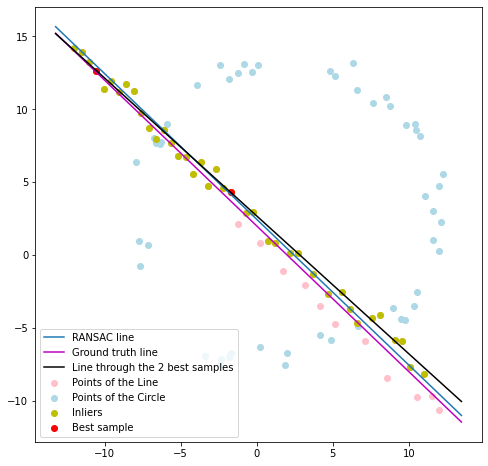

In [297]:
# Plotting the best fit line generated using ransac

fig, ax = plt.subplots(1,1, figsize=(8,8))
ax.scatter(X_line[:, 0], X_line[:, 1], color = 'pink', label='Points of the Line')
ax.scatter(X_circ[:, 0], X_circ[:, 1], color = 'lightblue', label='Points of the Circle')
ax.scatter(X_[best_inliers_line,0],X_[best_inliers_line,1], color='y', label='Inliers')
ax.scatter(best_sample_line[:,0],best_sample_line[:,1], color='r', label='Best sample')

x_min, x_max = ax.get_xlim()

x_ = np.array([x_min, x_max])
y_ = (-best_model_line[1]*x_ + best_model_line[2])/best_model_line[1]
plt.plot(x_, y_,  label='RANSAC line')

x_ = np.array([x_min, x_max])
y_ = m*x_ + c
plt.plot(x_, y_, color='m', label='Ground truth line')

y_ = (-a_/b_)*x_ + (d_/b_)
plt.plot(x_, y_, color='black', label='Line through the 2 best samples')

plt.legend()

In [298]:
# Now lets run a code snippet to substract the consensus of the best fit line

remaining_indices = [i for i in range(len(best_inliers_line)) if best_inliers_line[i]==False]
#print (remaining_indices)
remaining_points_of_line = X_line[remaining_indices]
#print(remaining_points_of_line)

# The remaining points of the line will be added to the points of the circle
X_new = np.vstack((X_circ, remaining_points_of_line))


In [299]:
#Let's estimate the circle that fits the remnant using RANSAC
def model_circle(point_list):
    """
    Returns the center and radius of the circle passing the given 3 points.
    """
    p1,p2,p3 = point_list[0], point_list[1], point_list[2]
    temp = p2[0] * p2[0] + p2[1] * p2[1]
    bc = (p1[0] * p1[0] + p1[1] * p1[1] - temp) / 2
    cd = (temp - p3[0] * p3[0] - p3[1] * p3[1]) / 2
    det = (p1[0] - p2[0]) * (p2[1] - p3[1]) - (p2[0] - p3[0]) * (p1[1] - p2[1])

    # Center of circle
    cx = (bc*(p2[1] - p3[1]) - cd*(p1[1] - p2[1])) / det
    cy = ((p1[0] - p2[0]) * cd - (p2[0] - p3[0]) * bc) / det

    radius = np.sqrt((cx - p1[0])**2 + (cy - p1[1])**2)
    return ((cx, cy), radius)

def get_inliers(data_list, center, r):
    """
    Returns the list of inliers to a model of a circle from a set of points.
    The threshold value is taken as 1/5th of the radius
    """
    inliers = []
    thresh = 0.5

    for i in range(len(data_list)):
        distance_to_center = np.sqrt((data_list[i][0]-center[0])**2 + (data_list[i][1]-center[1])**2)
        error = abs(distance_to_center - r)
        if error <= thresh:
            inliers.append(data_list[i])

    return np.array(inliers)

'''def random_sample(data_list):
    sample_list=[]
    sample_indices = np.random.choice(len(data_list), 3, replace=False)
    for j in sample_indices:
        sample_list.append(data_list[j])
    return np.array(sample_list)'''

def random_sample(data_list):
    lower_bound = 0
    upper_bound = len(data_list)
    num_random_numbers = 3
    rand_nums = random.sample(range(lower_bound, upper_bound ), num_random_numbers)
    sample_list = []
    for i in rand_nums:
        sample_list.append(data_list[i])
    return np.array(sample_list)

'''def random_sample(data_list):
    """
    Returns a list of 3 random samples from a given list
    """
    sample_list = []
    random.seed(0)
    rand_nums = random.sample(range(1, len(data_list)), 3)
    for i in rand_nums:
        sample_list.append(data_list[i])
    return np.array(sample_list)'''

def calc_R(x_, y_, xc, yc):
    """ calculate the distance of each 2D points from the center (xc, yc) """
    return np.sqrt((x_-xc)**2 + (y_-yc)**2)

def f_2(c, x_, y_):
    """ calculate the algebraic distance between the data points and the mean circle centered at c=(xc, yc) """
    Ri = calc_R(x_, y_, *c)
    return Ri - Ri.mean()

def estimateCircle(x_m, y_m, points):
    x_ = points[:,0]
    y_ = points[:,1]
    center_estimate = x_m, y_m
    center_2, ier = optimize.leastsq(f_2, center_estimate, (x_, y_))

    xc_2, yc_2 = center_2

    Ri_2 = calc_R(x_, y_, *center_2)
    R_2 = Ri_2.mean()
    # residu_2   = sum((Ri_2 - R_2)**2)
    return (xc_2, yc_2), R_2

In [223]:
# RANSAC_Circle
'''
def RANSAC_Circle(data_list, itr):
    """
    Return the center, radius and the best sample and its inliers used to fit the circle to a set of points using RANSAC_Circle
    """
    best_sample = []
    best_center_sample = (0,0)
    best_radius_sample = 0
    best_inliers = []
    max_inliers = 0
    
    for i in range(itr):
        samples = random_sample(data_list)  # Generating a random sample of 3 points
        center, radius = model_circle(samples) # Calculting the center and the radius of the circle created by the 3 points
        inliers = get_inliers(data_list, center, radius) # Get the list of inliers
        num_inliers = len(inliers)

        # If a better approximation has been reached
        if num_inliers > max_inliers:
            best_sample = samples
            max_inliers = num_inliers
            best_center_sample = center
            best_radius_sample = radius
            best_inliers = inliers

    print("Center of Sample=", best_center_sample)
    print("Radius of Sample=", best_radius_sample)

    return best_center_sample, best_radius_sample, best_sample, best_inliers
    '''

In [300]:
# RANSAC to fit a circle
# Outputs the center, radius,sample points and inliers of the circle passing through the best sample points
'''Provide the center of the intial estimate and the inliers as inputs to estimateCircle function
    to obtain the equation of the circle using scipy.optimize that fits all the inliers '''

def RANSAC_Circle(X, iterations):
    best_model = None
    best_inliers = []
    threshold = 0.5
    min_inliers = len(X)//2
    
    for _ in range(iterations):
        samples = random_sample(X)
        #sample_indices = np.random.choice(len(X), 3, replace=False)
        x1, y1 = samples[0][0],samples[0][1]
        x2, y2 = samples[1][0],samples[1][1]
        x3, y3 = samples[2][0],samples[2][1]
        
        center, radius = model_circle(samples)
        x_center,y_center =center[0],center[1]
        
        # Calculate the radial error of all points to the circle
        errors = np.abs(np.sqrt((X[:, 0] - x_center)**2 + (X[:, 1] - y_center)**2) - radius)
        
        # Find inliers based on the threshold
        #inliers = np.where(errors < threshold)[0]
        inliers = get_inliers(X, center, radius)
        
        if len(inliers) >= min_inliers:
            if len(inliers) > len(best_inliers):
                best_radius = radius
                best_center = center
                best_inliers = inliers
                best_sample = np.array(samples)
                
    return best_center,best_radius,best_sample, best_inliers

In [301]:
print(len(X_new))

61


In [302]:
# Calculting the RANSAC outputs for the data set
# Calculate the center and radius of the 
#circle passing through the 3 best samples

center, radius, sample, inliers = RANSAC_Circle(X_new, 10000)
print(center)

(1.981744522554937, 2.548342619428843)


Ratio of inliers = 57.377049180327866 %
Center of RANSAC = (2.043386619243174, 2.6387859619815144)
Radius of RANSAC = 10.204481889982532


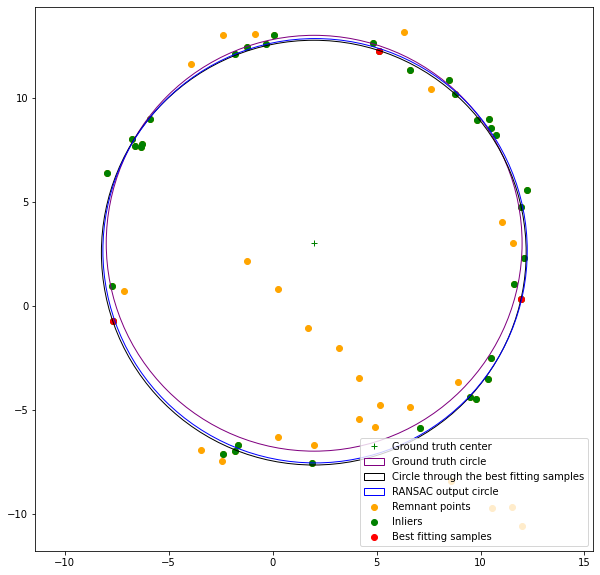

In [312]:
# Plotting
fig,ax = plt.subplots(1,1, figsize = (10,10))

#Plot the remaining points
ax.scatter(X_new[:, 0], X_new[:, 1], color = 'orange', label='Remnant points')

#The ground truth circle
circle_gt = plt.Circle((x0_gt, y0_gt), r, color='purple', fill=False, label='Ground truth circle')
ax.add_patch(circle_gt)

# The ground truth center
ax.plot(x0_gt, y0_gt, '+g', label='Ground truth center')

# Circle passing through the best fitting points
circle = plt.Circle(center, radius, fill = False, label = "Circle through the best fitting samples", color = 'k')
ax.add_patch(circle)

# Plotting the inliers
print("Ratio of inliers =",len(inliers)/len(X_new)*100, "%")
ax.scatter(inliers[:,0], inliers[:,1], color = 'green', label = "Inliers")

# Plotting the best fitting samples
ax.scatter(sample[:,0], sample[:,1], color = 'red', label = "Best fitting samples")

# Estimate the circle using the inliers using the least square method
ransac_center, ransac_radius = estimateCircle(center[0], center[1], inliers)

print("Center of RANSAC =", ransac_center)
print("Radius of RANSAC =", ransac_radius)

# Plotting the best estimate of the circle
circle = plt.Circle(ransac_center, ransac_radius, fill = False, label = "RANSAC output circle", color = 'b')
ax.add_patch(circle)
ax.axis('equal')


ax.legend()

In [313]:
for x in sample:
    print(x)
    print(x in X_circ)

[ 5.1328713  12.26447317]
True
[11.94670224  0.30503913]
True
[-7.68757359 -0.74362944]
True


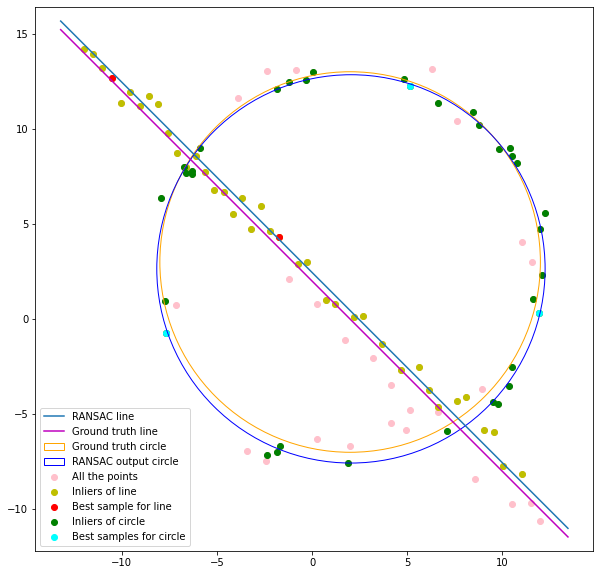

In [317]:
fig,ax = plt.subplots(1,1, figsize = (10,10))

#All the points
ax.scatter(X[:, 0], X[:, 1], color = 'pink', label='All the points')

# Inliers of the best model of the line
ax.scatter(X_[best_inliers_line,0],X_[best_inliers_line,1], color='y', label='Inliers of line')

# Best 2 samples of the line
ax.scatter(best_sample_line[:,0],best_sample_line[:,1], color='r', label='Best sample for line')

x_min, x_max = ax.get_xlim()

#Ground truth line
x_ = np.array([x_min, x_max])
y_ = (-best_model_line[1]*x_ + best_model_line[2])/best_model_line[1]
plt.plot(x_, y_,  label='RANSAC line')

#RANSAC line
x_ = np.array([x_min, x_max])
y_ = m*x_ + c
plt.plot(x_, y_, color='m', label='Ground truth line')

# Inliers of the best model of the circle
ax.scatter(inliers[:,0], inliers[:,1], color = 'green', label = "Inliers of circle")

# Best 3 sample points of the estimate of the circle
ax.scatter(sample[:,0], sample[:,1], color = 'cyan', label = "Best samples for circle")

#Ground truth circle
circle_gt = plt.Circle((x0_gt, y0_gt), r, color='orange', fill=False, label='Ground truth circle')
ax.add_patch(circle_gt)

#RANSAC circle
circle = plt.Circle(ransac_center, ransac_radius, fill = False, label = "RANSAC output circle", color = 'b')
ax.add_patch(circle)
ax.axis('equal')


ax.legend()

